In [1]:
import xgboost
import numpy as np
import shap

In [5]:
import seaborn as sns

## create X and y

In [2]:
N = 2000
X = np.zeros((N,5))
X[:1000,0] = 1
X[:500,1] = 1
X[1000:1500,1] = 1
X[:250,2] = 1
X[500:750,2] = 1
X[1000:1250,2] = 1
X[1500:1750,2] = 1
X[:,0:3] -= 0.5
y = 2*X[:,0] - 3*X[:,1]

In [3]:
X

array([[ 0.5,  0.5,  0.5,  0. ,  0. ],
       [ 0.5,  0.5,  0.5,  0. ,  0. ],
       [ 0.5,  0.5,  0.5,  0. ,  0. ],
       ...,
       [-0.5, -0.5, -0.5,  0. ,  0. ],
       [-0.5, -0.5, -0.5,  0. ,  0. ],
       [-0.5, -0.5, -0.5,  0. ,  0. ]])

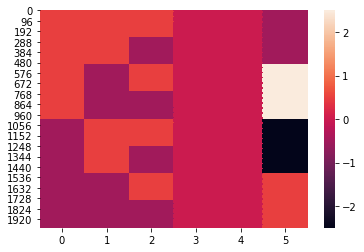

In [8]:
ax = sns.heatmap(np.c_[X, y])

In [9]:
# ensure the variables are independent
np.cov(X.T)

array([[0.25012506, 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.25012506, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.25012506, 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ]])

In [10]:
# and mean centered
X.mean(0)

array([0., 0., 0., 0., 0.])

In [13]:
# train a model with single tree
Xd = xgboost.DMatrix(X, label=y)

model = xgboost.train(
    {'eta':1, 'max_depth':3, 'base_score': 0, "lambda": 0}, 
    Xd, 
    1)

print("Model error =", np.linalg.norm(y-model.predict(Xd)))
print("++++++++++++++++++++++++++++++++")
print(model.get_dump(with_stats=True)[0])

Model error = 0.0
++++++++++++++++++++++++++++++++
0:[f1<0] yes=1,no=2,missing=1,gain=4500,cover=2000
	1:[f0<0] yes=3,no=4,missing=3,gain=1000,cover=1000
		3:leaf=0.5,cover=500
		4:leaf=2.5,cover=500
	2:[f0<0] yes=5,no=6,missing=5,gain=1000,cover=1000
		5:leaf=-2.5,cover=500
		6:leaf=-0.5,cover=500



In [14]:
# make sure the SHAP values add up to marginal predictions
pred = model.predict(Xd, output_margin=True)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(Xd)
np.abs(shap_values.sum(1) + explainer.expected_value - pred).max()

0.0

In [15]:
shap_values.shape

(2000, 5)

## SHAP Interaction Values

In [19]:
shap_interaction_values = explainer.shap_interaction_values(Xd)

print(shap_interaction_values.shape)
print("+++++++++++++++++++++++++++")
print(shap_interaction_values[0])

(2000, 5, 5)
+++++++++++++++++++++++++++
[[ 1.   0.   0.   0.   0. ]
 [ 0.  -1.5  0.   0.   0. ]
 [ 0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0. ]]
